## BUS to TCC and Gene Count Matrices 

**basic steps**: cell detection, barcode error correction and ec-umi intersection

--------------------
#### - **Input**: 
- requires sorted bus file `output.bus.sorted.txt` (bustools) and the corresponding  ec/tx files `matrix.ec`, `transcripts.txt`. Also uses the `_tr2g.pickle` and `_g2n.pickle` files (generated by the `get_dicts-from-ref.ipynb` notebook).

#### - **Workflow overview**: 
   - **cell detection**: cell detection is based on the expected cells parameter with optional whitelist filtering (set *parameter['whitelist']=None* if no whitelist is available)
   - **error correction**: barcode error correction is performed at hamming distance-1 for all cell barcodes that are at least *parameter['dmin']* away from the rest. (it is suggested to set dmin=3 to avoid almost all ambiguous barcode collisions).
   - **ec-umi intersection**: within each cell, the equivalence classes with the same umi (i.e., originating from the same transcript) are intersected to provide more specific pseudo-alignment information. This makes sense when PCR amplification precedes read fragmentation in library preparation (e.g., 10x) and can significantly increase the isoform-level information extracted from the data. This information is also useful for the gene count matrix to prevent over-deduplication of umis when aggregating at the gene-level.

#### - **Output**: 
  - The TCC and the corresponding Gene Counts matrices for the same cells in mtx format: `matrix.tcc.mtx` and `GCmatrix.mtx` along with the corresponding .cells and .genes files.
___________

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
!date

Wed Dec 19 12:21:46 PST 2018


In [2]:
# requires files: 'output.bus.sorted.txt', 'matrix.ec', 'transcripts.txt'
parameter={'busdir':'/home/vasilis/datasets/10x/t4k/bus/',
           'output':'/home/vasilis/scratch/BUS/github_notebooks/t4k_out/',
           'whitelist':'/home/vasilis/refs/10xwhitelist.txt',
           'refdata':'/home/vasilis/refs/',
           'LANE':1,
           'EXP_CELLS':6000,
           'NUM_THREADS':16,
           'dmin': 3}

# the following dict files can be generated by the get_dicts-from-ref.ipynb notebook and should be placed 
# in the parameter['refdata'] directory
tr2g_file='Homo_sapiens.GRCh38_tr2g.pickle' 
g2n_file='Homo_sapiens.GRCh38_g2n.pickle'

len_of_ens=15 #ENSG+11 #for Mus.Musculus it should be 18: ENSMUSG+11

In [3]:
#create output directory 
save_dir=str(parameter["output"])
import os
if not os.path.isdir(save_dir):
    try:
        os.mkdir(save_dir)
    except OSError as e:
        print("OSError({0}): {1}".format(e.errno, e.strerror))

### load data + dicts

In [4]:
import csv
from collections import defaultdict
import pandas as pd

In [5]:
%%time
busdir=str(parameter["busdir"])

# load equivalence classes
ecs = {}
with open(busdir+'matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        

# if parameter['whitelist']!=0:
whitelist = set(x.strip() for x in open(parameter['whitelist']))

CPU times: user 3.11 s, sys: 346 ms, total: 3.46 s
Wall time: 3.39 s


In [6]:
%%time
barcodes=np.array(pd.read_csv(busdir+'output.bus.sorted.txt',delimiter='\t',usecols=[0],header=None, dtype=str)).reshape(-1,)

CPU times: user 19.4 s, sys: 1.08 s, total: 20.5 s
Wall time: 20.5 s


## choose codewords (i.e., original barcodes assigned to cells)

In [7]:
from collections import Counter
import math

counts = Counter(barcodes)
labels, values = zip(*counts.items())
# sort the values in descending order
indSort = np.argsort(values)[::-1]
# rearrange the data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indices = np.arange(len(labels))
print("NUM_OF_DISTINCT_BARCODES =",len(indices))

NUM_OF_DISTINCT_BARCODES = 1061491


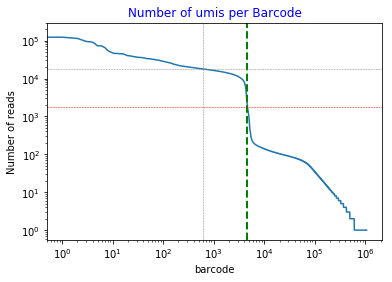

Cell_barcodes_detected: 4638
NUM_OF_UMIS_in_CELL_BARCODES = 61774320


In [8]:
EXP_CELLS=parameter['EXP_CELLS']

t=int(math.floor(EXP_CELLS * 0.1))
exp_values = np.where(values >= values[t] / 10)

NUM_OF_BARCODES = np.shape(exp_values)[1]

fig, ax = plt.subplots()
ax.plot(indices, (values))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Number of reads', color='k')
ax.set_xlabel('barcode', color='k')
ax.set_title('Number of umis per Barcode', color='b')
ax.axvline(t, color='gray', linestyle='--',linewidth=.5)
ax.axvline(NUM_OF_BARCODES, color='g', linestyle='--',linewidth=2.0)
ax.axhline(values[t], color='gray', linestyle='--',linewidth=.5)
ax.axhline(values[t]/10, color='red', linestyle='--',linewidth=.5)
fig.savefig(save_dir+'umi_barcodes.png')
plt.show()

if parameter['whitelist']!=0:
    mask=[i in whitelist for i in labels[:NUM_OF_BARCODES]]
else:
    mask=[True]*NUM_OF_BARCODES

codewords=labels[:NUM_OF_BARCODES][mask]
print("Cell_barcodes_detected:",len(codewords))
NUM_OF_UMIS_in_CELL_BARCODES=sum(values[:NUM_OF_BARCODES][mask])
print("NUM_OF_UMIS_in_CELL_BARCODES =",NUM_OF_UMIS_in_CELL_BARCODES)

In [9]:
#free some memory
import gc
del indices,labels,values,counts,indSort,whitelist; 
_ = gc.collect()

#### Choose the barcodes to be error corrected (based on dmin)

In [10]:
def hamdist(s1, s2):
    return sum(ch1 != ch2 for ch1, ch2 in zip(s1, s2))

###########################################
def is_far_enough(i):
    d=parameter['dmin']
    dmin=100000
    codi=codewords[i]
    j_range=list(np.arange(1,i))+list(np.arange(i+1,len(codewords)))
    while dmin>=d and len(j_range)>0:
        j=j_range.pop()
        dmin=np.min([dmin,hamdist(codi,codewords[j])])

    return i if dmin>=d else -1
########################################### 

In [11]:
from multiprocessing import Pool

In [12]:
%%time

brc_idx_to_correct=[]
p=Pool(parameter['NUM_THREADS'])
ret_vec=p.map(is_far_enough, np.arange(len(codewords)) )
p.close()
p.join()

brc_idx_to_correct = [i for i in ret_vec if i>=0]
print("-- number of cell barcodes to error-correct:", len(brc_idx_to_correct), "( dmin >=", parameter['dmin'],")" )

-- number of cell barcodes to error-correct: 4205 ( dmin >= 3 )
CPU times: user 63.4 ms, sys: 213 ms, total: 277 ms
Wall time: 11.5 s


### error-correct

In [13]:
from itertools import chain, combinations, product,compress
def hamming_circle(s, n, alphabet='ATCG'):
    """Generate strings over alphabet whose Hamming distance from s is
    exactly n.
    """
    for positions in combinations(range(len(s)), n):
        for replacements in product(range(len(alphabet) - 1), repeat=n):
            cousin = list(s)
            for p, r in zip(positions, replacements):
                if cousin[p] == alphabet[r]:
                    cousin[p] = alphabet[-1]
                else:
                    cousin[p] = alphabet[r]
            yield ''.join(cousin)


def merge_barcodes(barcs):
    offset=barcs[0]
    barcs=barcs[1]
    retvec=[]
    for idd in range(len(codewords)):
        retvec+=[[]]
    for idx, barcode in enumerate(barcs):
        if barcode in codeword_set: retvec[cw[barcode]] +=[idx+offset]
        else:
            if barcode in brc_to_correct_neigbors:
                neighbors = hamming_circle(barcode,1)
                for neighbor in neighbors:
                    if neighbor in brc_to_correct: retvec[cw[neighbor]] +=[idx+offset]; break;
    return retvec

#### link barcodes to their closest codewords

In [14]:
%%time
#######################################################
chunksize=1+int(len(barcodes)/parameter['NUM_THREADS'])
    
cw={}
for id in range(len(codewords)):
    cw[codewords[id]] = id
    
barcode_split=[]
for i in range(0, len(barcodes), chunksize):
    barcode_split+=[[i,barcodes[i:i+chunksize]]]
    
codeword_set = set(codewords)
codeword_list = list(codewords)
brc_to_correct=set(codewords[brc_idx_to_correct])


#### Generate the set of all dist-1 neighbors of brc_to_correct (for fast check in merge func)
#### note: the number of barcodes in this set is len(brc_to_correct)*3*barcode_length
brc_to_correct_neigbors=set()
for brc in brc_to_correct:
    neighbors = hamming_circle(brc,1)
    for neighbor in neighbors:
        brc_to_correct_neigbors.add(neighbor)
#######################################################
        
        
p = Pool(parameter['NUM_THREADS'])
ret_threads=p.map(merge_barcodes, barcode_split)
p.close(); p.join()

ret_vec=[]
for idd in range(len(codewords)):
    idx_list=[]
    for t in range(len(ret_threads)):
        idx_list+=ret_threads[t][idd]
    ret_vec+=[idx_list]

CPU times: user 6.3 s, sys: 2.69 s, total: 8.98 s
Wall time: 10.5 s


In [15]:
reads_per_barcode=[]
for i in range(len(codewords)):
    reads_per_barcode+=[len(ret_vec[i])]
    
NUM_OF_UMIS_in_error_corrected_CELL_BARCODES=sum(reads_per_barcode)
print("NUM_OF_UMIS_in_CELL_BARCODES (after error-correct):",NUM_OF_UMIS_in_error_corrected_CELL_BARCODES)
print("NUM_OF_UMIS_rescued :",NUM_OF_UMIS_in_error_corrected_CELL_BARCODES - NUM_OF_UMIS_in_CELL_BARCODES)
print("Percent UMI increase: {:.3}%'".format(100*(NUM_OF_UMIS_in_error_corrected_CELL_BARCODES - NUM_OF_UMIS_in_CELL_BARCODES)/NUM_OF_UMIS_in_CELL_BARCODES))

NUM_OF_UMIS_in_CELL_BARCODES (after error-correct): 63372195
NUM_OF_UMIS_rescued : 1597875
Percent UMI increase: 2.59%'


In [16]:
%%time
b2c={} #barcode to codeword dict
for i in range(len(ret_vec)):
    for j in ret_vec[i]:
        b2c[barcodes[j]]=i

CPU times: user 7.51 s, sys: 700 ms, total: 8.21 s
Wall time: 8.21 s


In [17]:
#free some memory
del brc_to_correct_neigbors,ret_vec[:]
_ = gc.collect()

### read BUSfile and create map cells to (ec,umi)-sets

In [18]:
%%time
cellsets = {i:set() for i in range(len(codewords))} # this set will collapse duplicate ec-umis in each cell
num_tx_aligned_reads = 0
with open(busdir+'output.bus.sorted.txt') as f:
    rdr = csv.reader(f, delimiter='\t')
    for bar,umi,ec,c in rdr:
        num_tx_aligned_reads+=int(c)
        try:
            cell = b2c[bar]
            cellsets[cell].add((int(ec),umi))
            
        except KeyError: pass  
        
# # from set back to sorted list
# for c in range(len(cellsets)):
#     cellsets[c]=sorted(list(cellsets[c]),key=lambda x: x[1])
    
#free memory
b2c.clear(); del b2c
_ = gc.collect()

CPU times: user 1min 25s, sys: 9.28 s, total: 1min 35s
Wall time: 1min 34s


# intersect equivalence classes / UMIS

### tx_set to ec_id dict

In [19]:
%%time
s2ec = {} #set to ec dict
for ec in ecs.keys():
    s2ec[frozenset(ecs[ec])]=ec

ecs_sets={i:set(ecs[i]) for i in ecs.keys()} # precomputed ec to tx_sets dict

CPU times: user 21.1 s, sys: 1.26 s, total: 22.3 s
Wall time: 22.3 s


In [20]:
%%time
new_cellsets={}
gc.disable() #disable automatic garbage collection for this iteration (collect in the end)

from tqdm import tqdm_notebook as tqdm # if not installed use the regular for loop in the comment below 
for c in tqdm(range(len(cellsets))): # for c in range(len(cellsets)):
    new_cellsets[c]=set()
    cell = cellsets[c]
    umi_dict=defaultdict(list)
    for i in cell:
        umi_dict[i[1]].append(ecs_sets[i[0]])

    for umi in umi_dict.keys(): 
        ec_list=sorted(umi_dict[umi],key=len,reverse=1)
        k=len(ec_list)
        done = False
        new_ec = set.intersection(*ec_list)
        if len(new_ec) > 0:
            ec_list=[new_ec];
            done = True;     
        while(not done):
            done=True
            for i,j in combinations(range(k), 2): 

                new_ec = ec_list[i].intersection(ec_list[j])
                if len(new_ec) > 0:
                    #print((i,j),"new_ec: ",new_ec)
                    #print('      in ecs? ',frozenset(new_ec) in s2ec)
                    msk=np.ones(k,dtype=bool);msk[[i,j]]=False
                    ec_list= [u for u in compress(ec_list, msk)]+[new_ec]
                    k-=1;done=False; break;
                    #print(ec_list);
                        
        for new_ec in ec_list:
            try: 
                new_cellsets[c].add((s2ec[frozenset(new_ec)],umi))
                #print((s2ec[frozenset(new_ec)],umi))
            except KeyError:
                new_id=len(ecs)
                listoftx=list(new_ec);listoftx.sort()
                ecs[new_id] = listoftx
                s2ec[frozenset(new_ec)] = new_id
                new_cellsets[c].add((s2ec[frozenset(new_ec)],umi))
    
    
gc.enable()
_ = gc.collect()


CPU times: user 2min 54s, sys: 11 s, total: 3min 5s
Wall time: 3min 3s


In [21]:
## free some memory
s2ec.clear(); ecs_sets.clear()
del s2ec,ecs_sets
_ = gc.collect()

##### stats

5046 13305
2854 5079


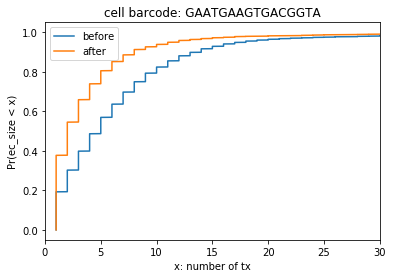

8644 28519
5236 10923


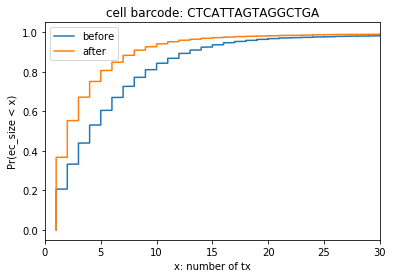

5176 13979
2886 5244


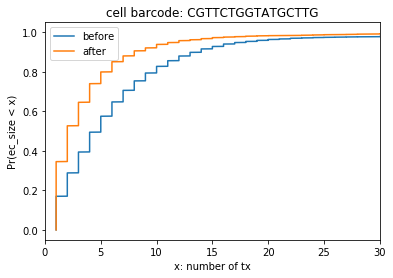

In [22]:
#three random cells before and after
from statsmodels.distributions.empirical_distribution import ECDF

cnt=1
for c in np.random.randint(0,len(codewords),3):
    labels, values = zip(*Counter([i[0] for i in cellsets[c]]).items())
    print(len(labels),sum(values))
    ecdf = ECDF([len(ecs[i]) for i in labels])
    plt.plot(ecdf.x,ecdf.y)
    labels, values = zip(*Counter([i[0] for i in new_cellsets[c]]).items())
    print(len(labels),sum(values))
    ecdf = ECDF([len(ecs[i]) for i in labels])
    plt.plot(ecdf.x,ecdf.y)
    plt.xlim([0,30])
    plt.title( 'cell barcode: {:1}'.format(codewords[c]))
    plt.xlabel('x: number of tx')
    plt.ylabel('Pr(ec_size < x)')
    plt.legend(['before','after'])
    fig.savefig(save_dir+'ec_intersection_example_cell_'+str(cnt)+'.png')
    cnt+=1
    plt.show()
        

In [23]:
cellsets.clear(); del cellsets; #free memory
_ = gc.collect()

## get tcc matrix

In [24]:
from scipy.sparse import coo_matrix

In [25]:
%%time
ec_set=set()
for c in range(len(codewords)):
    ec_set.update([i[0] for i in new_cellsets[c]])
    
equivalence_classes=list(ec_set)
equivalence_classes.sort()


tmp={}
for id in range(len(equivalence_classes)):
    tmp[equivalence_classes[id]] = id

CPU times: user 3.44 s, sys: 247 ms, total: 3.68 s
Wall time: 3.68 s


In [26]:
%%time
row=[]
col=[]
data=[]

for c in range(len(codewords)):
    labels, values = zip(*Counter([i[0] for i in new_cellsets[c]]).items())
    col+= [c] * len(labels)
    row+=[tmp[ec] for ec in labels]
    data+=values
A=coo_matrix((data, (row, col)), shape=(len(equivalence_classes),len(codewords)))

CPU times: user 31.7 s, sys: 1.35 s, total: 33.1 s
Wall time: 33 s


In [27]:
del row,col,data

#### stats

In [28]:
print('MEDIAN_UMI_COUNTs:',int(np.median(np.array(A.sum(axis=0))[0])))

MEDIAN_UMI_COUNTs: 5019


In [29]:
# # # # # # # # # # # # # # # # # # # # # # # # #
#(will also be used later for gene count matrix)#
# # # # # # # # # # # # # # # # # # # # # # # # #

# load transcripts        
trlist = []
with open(busdir+'transcripts.txt') as f:
    for line in f:
        trlist.append(line[:-3])

with open(parameter['refdata']+tr2g_file, 'rb') as handle:
    tr2g = pickle.load(handle)

with open(parameter['refdata']+g2n_file, 'rb') as handle:
    g2n = pickle.load(handle)
    
# ec to gene names 
ec2gn = {ec:frozenset([item for sublist in  [g2n[tr2g[trlist[t][:len_of_ens]]] for t in ecs[ec]]   for item in sublist ]) for ec in equivalence_classes}



################### STATS ##########################
## counts vs gene multimapping (size here is the number of *gene names* that an eq.class maps to )
ec_counts=np.array(A.sum(axis=1)).T[0]
counts_sz =np.zeros(1000)
for ec in equivalence_classes:
    cnt=ec_counts[tmp[ec]]
    sz=len(ec2gn[ec])
    try:
        counts_sz[sz-1]+=cnt
    except:
        pass
counts_sz=100*counts_sz/sum(counts_sz)

print('n_genes\tpercent_counts')
for i in range(10):
    
    print(i+1,'\t{:.2f}%'.format(counts_sz[i]))

n_genes	percent_counts
1 	90.05%
2 	5.53%
3 	1.63%
4 	0.79%
5 	0.42%
6 	0.23%
7 	0.17%
8 	0.23%
9 	0.10%
10 	0.08%


In [30]:
print('Will keep {:.1f}% more reads in TCCs'.format(100*(100-counts_sz[0])/counts_sz[0]))

Will keep 11.1% more reads in TCCs


In [31]:
# UMI deduplication rate
print('number_of_TCC_deduplicated_umis/transcriptome_aligned_reads:\t{:.1f}%'.format(100*A.sum()/num_tx_aligned_reads))

number_of_TCC_deduplicated_umis/transcriptome_aligned_reads:	11.0%


### write tcc matrix

In [32]:
from scipy.io import mmwrite

In [33]:
%%time
mmwrite(save_dir+'matrix.tcc.mtx',A)

CPU times: user 15.7 s, sys: 315 ms, total: 16 s
Wall time: 16.2 s


In [34]:
with open(save_dir+'matrix.ec','w') as of:
    for ec in equivalence_classes:
        transcripts = ",".join([str(i) for i in ecs[ec]])
        of.write("%s\t%s\n"%(str(ec),transcripts))

In [35]:
with open(save_dir+'matrix.cells','w') as of:
    of.write('\n'.join(x + '-' + str(parameter['LANE']) for x in codewords))
    of.write('\n')

# Gene Counts

### gene names to ec ( gn2ec dict, ec2gn is already computed )

In [36]:
gn2ec={}
for ec in equivalence_classes:
    for gn in ec2gn[ec]:
        try:
            gn2ec[gn].update([ec])
        except KeyError:
            gn2ec[gn] = set([ec])

##### simple gene counts

In [37]:
cell_gene = defaultdict(lambda: defaultdict(float))

In [38]:
%%time
from tqdm import tqdm_notebook as tqdm # if not installed use the regular for loop in the comment below
for c in tqdm(range(len(codewords))):#for c in range(len(codewords)):
    for ec,umi in new_cellsets[c]:
        gs=ec2gn[ec]
        if len(gs)==1:
            cell_gene[c][gs] += 1
        
# #### additional UMI collapsing at the gene level:
# from tqdm import tqdm_notebook as tqdm # if not installed use the regular for loop in the comment below
# for c in tqdm(range(len(codewords))):#for c in range(len(codewords)):
#     gs2umi={}
#     for ec,umi in new_cellsets[c]:
#         gs=ec2gn[ec]
#         if len(gs)==1:
#             try:
#                 gs2umi[ec2gn[ec]].add(umi)
#             except KeyError:
#                 gs2umi[ec2gn[ec]] = set([umi])   
#     for g in gs2umi.keys():
#         cell_gene[c][g] += len(gs2umi[g])


CPU times: user 21.5 s, sys: 2.41 s, total: 23.9 s
Wall time: 23.6 s


## get gene counts matrix

In [39]:
%%time
gene_set=set()
for c in range(len(codewords)):
    gene_set.update(cell_gene[c])
    
genes=list(gene_set)

tmp2={}
for id in range(len(genes)):
    tmp2[genes[id]] = id

CPU times: user 812 ms, sys: 102 ms, total: 914 ms
Wall time: 909 ms


In [40]:
%%time
row=[]
col=[]
data=[]

for c in range(len(codewords)):
    row+=[tmp2[gene] for gene,_ in cell_gene[c].items()]
    data+=[round(val) for _,val in cell_gene[c].items()]
    col+= [c] * len(cell_gene[c])
    
    
B=coo_matrix((data, (row, col)), shape=(len(genes),len(codewords)))

CPU times: user 5.98 s, sys: 261 ms, total: 6.24 s
Wall time: 6.24 s


In [41]:
del row,col,data
_ = gc.collect()

##### stats

In [42]:
print('(gene) MEDIAN_UMI_COUNTs:',int(np.median(np.array(B.sum(axis=0))[0])))
print('(tccs) MEDIAN_UMI_COUNTs:',int(np.median(np.array(A.sum(axis=0))[0])))

(gene) MEDIAN_UMI_COUNTs: 4522
(tccs) MEDIAN_UMI_COUNTs: 5019


In [43]:
print('(consistency) gene_counts/tcc:\t{:.2f}%'.format(100*B.sum()/A.sum()))

(consistency) gene_counts/tcc:	90.05%


In [44]:
# UMI deduplication RATE
print('(gene) number_of_deduplicated_umis/transcriptome_aligned_reads:\t{:.1f}%'.format(100*B.sum()/num_tx_aligned_reads))
print('(tccs) number_of_deduplicated_umis/transcriptome_aligned_reads:\t{:.1f}%'.format(100*A.sum()/num_tx_aligned_reads))

(gene) number_of_deduplicated_umis/transcriptome_aligned_reads:	9.9%
(tccs) number_of_deduplicated_umis/transcriptome_aligned_reads:	11.0%


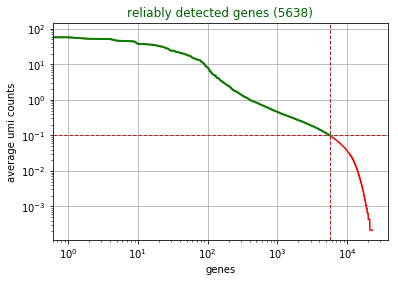

reliably detected genes: 5638


In [45]:
fig, ax = plt.subplots()
t=np.sum(np.array(B.mean(axis=1))>0.1)
ax.grid()
ax.plot(np.sort(np.array(B.mean(axis=1)),axis=0).T[0][::-1],color='r')
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('average umi counts', color='k')
ax.set_xlabel('genes', color='k')
ax.set_title('reliably detected genes ('+str(t)+')', color='darkgreen')
ax.axhline(0.1, color='firebrick', linestyle='--',linewidth=1)
ax.axvline(t, color='firebrick', linestyle='--',linewidth=1)
ax.plot(np.sort(np.array(B.mean(axis=1)),axis=0).T[0][::-1][:t],color='green',linewidth=2)
fig.savefig(save_dir+'mean_gene_counts.png')
plt.show()

print('reliably detected genes:',t)

### write gene matrix

In [46]:
%%time
mmwrite(save_dir+'GCmatrix.mtx',B)

CPU times: user 8.91 s, sys: 233 ms, total: 9.14 s
Wall time: 9.02 s


In [47]:
with open(save_dir+'GCmatrix.genes','w') as of:
    for g in genes:
        of.write("%s\n"%g)

In [48]:
with open(save_dir+'GCmatrix.cells','w') as of:
    of.write('\n'.join(x + '-' + str(parameter['LANE']) for x in codewords))
    of.write('\n')

In [49]:
!date

Wed Dec 19 12:30:12 PST 2018
